In [123]:
%matplotlib inline

import fipy as fp
import fipy.tools.numerix as numerix

In [124]:
nx = 200
ny = 200
dx = 0.5
dy = 0.5
mesh = fp.Grid2D(nx=nx, ny=ny, dx=dx, dy=dy)

In [132]:
delta = 0.0
mm = 4
epsilon_m = 0.025
theta_0 = 0.0
tau_0 = 1.
DD = 10.
W_0 = 1.
lamda = DD * tau_0 / 0.6267 / W_0**2
delta = -0.05

In [139]:
phase = fp.CellVariable(mesh=mesh, hasOld=True)
phase[:] = -1.0
x, y = mesh.cellCenters
radius = 2.0
center = (nx * dx / 2., ny * dy / 2.)
mask = (x - center[0])**2 + (y - center[1])**2 < radius**2
phase.setValue(1., where=mask)
uu = fp.CellVariable(mesh=mesh, hasOld=True)
uu.constrain(-delta, mesh.exteriorFaces)
uu[:] = -delta
dt = fp.Variable(0.1)

In [140]:
def make_tau(phase_):
    theta_cell = numerix.arctan2(phase_.grad[1], phase_.grad[0])
    a_cell = 1 + epsilon_m * numerix.cos(mm * theta_cell + theta_0)
    return tau_0 * a_cell**2

tau = make_tau(phase)
tau_old = make_tau(phase.old)

In [141]:
source_explicit = 2 * phase**3 - lamda * uu * (1 - phase**2) * (1 + 3 * phase**2)
source_implicit = (1 - 3 * phase**2) + 4 * lamda * uu * phase * (1 - phase**2)

In [142]:
theta = numerix.arctan2(phase.faceGrad[1], phase.faceGrad[0])
W = W_0 * (1 + epsilon_m * numerix.cos(mm * theta + theta_0))

W_theta = - W_0 * mm * epsilon_m * numerix.sin(mm * theta + theta_0)

I0 = fp.Variable(value=((1,0), (0,1)))
I1 = fp.Variable(value=((0,-1), (1,0)))

Dphase = W**2 * I0 + W * W_theta * I1

In [143]:
heat_eqn = fp.TransientTerm() == fp.DiffusionTerm(DD) + (phase - phase.old) / dt / 2.

phase_eqn = fp.TransientTerm(tau) == fp.DiffusionTerm(Dphase) + source_explicit + \
            fp.ImplicitSourceTerm(source_implicit) + fp.ImplicitSourceTerm((tau - tau_old) / dt)

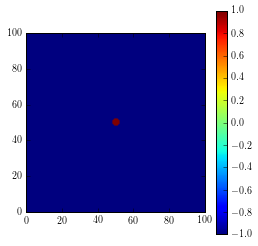

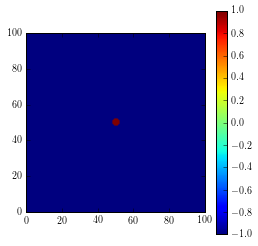

In [144]:
phase_viewer = fp.Viewer(phase)
phase_viewer.plot()

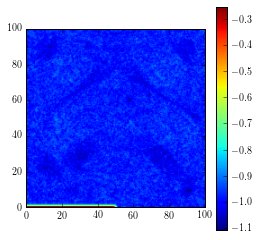

In [145]:
phase[:] = -1.0
phase[:nx / 2] = 1.0
uu[:] = 0.0
dt.setValue(0.1)
steps = 4
sweeps = 4
from fipy.solvers.pysparse import LinearLUSolver as Solver
solver = Solver()
saved_values = []
for step in range(steps):
    uu.updateOld()
    phase.updateOld()
    for sweep in range(sweeps):
        res_heat = heat_eqn.sweep(uu, dt=dt.value, solver=solver)
        res_phase = phase_eqn.sweep(phase, dt=dt.value, solver=solver)
        print res_heat
        print res_phase
    if step % 10:
        saved_values.append(phase.value)
phase_viewer.plot()


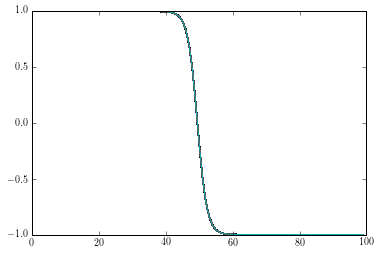

In [119]:
import matplotlib.pyplot as plt
import numpy as np

for value in saved_values:
    plt.plot(value)